# Employee and Bus Stops

## Context

A company XYZ intends to provide a bus shuttle service that would help its employees commute to the office. The company is based in Mountain View and the shuttle would provide transportation for employees based in San Francisco.

The city of San Francisco has given the company a list of potential bus stops that it may use. However, the company may use no more than 10 of these bus stops for its shuttle service.

The company XYZ is asking you to come up with the **10 most efficient bus stops** that would best serve its employees. Generally speaking, these "efficient" stops would result in the least walking distances between the employees' homes and their respective bus stops. To that end, you were given the following data:
- the list of bus stops provided by the city of San Francisco, `Bus_Stops.csv`
- a list of its employees' home addresses, `Employee_Addresses.csv`

Since trying out all possible combinations of 10 bus stops would take a prohibitively long time, the boss of XYZ has told you that you may simplify the problem and come up with 10 reasonable bus stops that are probably efficient.

## Objectives

- Explore and analyze the data. Provide comments on the outputs of your code and document your code well. 
- Feel free to show off your map visualization skills.
- Write an algorithm that produces the 10 best stops in your opinion. Also, please explain the rationale behind the algorithm. 
- Please the calculate the average walking distance per employee to their respective stops and report it at the end of your work.
- You may code the solution for this task in either Python or R. If you are coding in Python, you may enter your solution at the bottom of this notebook. Otherwise, you may create a new R jupyter notebook and copy this problem description over there. Either way, your solution is to be in the form of a jupyter notebook, regardless of the programming language used.
- Submit your work along with the data files used (`Bus_Stops.csv` & `Employee_Addresses.csv`) in a single ZIP file named as follows: `<FirstName>_<LastName>.zip`

## Evaluation

***Your solution will be evaluated on:***
- ***The soundness of the algorithm used to select the bus stops.***
- ***How much your code is neat, clear and well-documented.***
- ***Quality of narrative and commentary with interesting analyses and visuals.***

## Supplementary Notes

Prior to writing the requested algorithm, you will need to *geocode* the employees' home addresses and bus stops. You may use the [HERE REST APIs](https://developer.here.com/develop/rest-apis) for that purpose. Following are some links to help you in your task:
- To generate a free HereMaps account and an API Key to use for geocoding the addresses:  
    - https://developer.here.com/documentation/identity-access-management/dev_guide/topics/plat-using-apikeys.html
- Sections pertaining to *geocoding* in the documentation:  
    - https://developer.here.com/documentation/geocoder/dev_guide/topics/example-geocoding-free-form.html  
    - https://developer.here.com/documentation/geocoder/dev_guide/topics/example-geocoding-intersection.html
- Programmatically perform GET requests
    - Python: https://realpython.com/python-requests/
    - R: https://www.rdocumentation.org/packages/httr/versions/1.4.4

Note that HereMaps allows a maximum of 1000 requests per day, so it will take more than a single day to do all the geocoding. As a start, you may use all bus stops (~120 stops) and a few hundred employee addresses to start developing your algorithm. Save whatever you geocode so you would not need to geocode it again. Once the geocoding is done for all addresses, run the algorithm one last time and finalize your work.

*Side Note:*  
*The use of HereMaps API for geocoding is just one suggestion. If you are more comfortable using GoogleMaps API or OpenStreetMaps API, then you may use that as well. There are no constraints as to what you may use for geocoding of the addresses.*

<BR>
<BR>
<center><b><u>Finally, note that we will re-run your code (without the geocoding part) to make sure that your work is reproducible.</u></b></center>

<BR>
<center>
<H2>*** GOOD LUCK ***</H2>
</center>

--------

## Importing packages

In [2]:
import pandas as pd 
import numpy as np
import requests
import json

import matplotlib.pyplot as plt 
%matplotlib inline
import plotly.graph_objects as go

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestCentroid
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.cluster.hierarchy import dendrogram, linkage

import haversine as hs
from haversine import Unit

## Read Data 

In [3]:
bus_stops = pd.read_csv("Bus_Stops.csv")
employee_addresses = pd.read_csv("Employee_Addresses.csv")

## Exploring Data 

In [3]:
print("Bus stops shape: ", bus_stops.shape)
bus_stops.head()

Bus stops shape:  (119, 2)


,Street_One,Street_Two
0,MISSION ST,ITALY AVE
1,MISSION ST,NEW MONTGOMERY ST
2,MISSION ST,01ST ST
3,MISSION ST,20TH ST
4,MISSION ST,FREMONT ST


In [4]:
print("Employee addresses shape: ", bus_stops.shape)
employee_addresses.head()

Employee addresses shape:  (119, 2)


,address,employee_id
0,"98 Edinburgh St, San Francisco, CA 94112, USA",206
1,"237 Accacia St, Daly City, CA 94014, USA",2081
2,"1835 Folsom St, San Francisco, CA 94103, USA",178
3,"170 Cambridge St, San Francisco, CA 94134, USA",50
4,"16 Roanoke St, San Francisco, CA 94131, USA",1863


In [5]:
bus_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Street_One  119 non-null    object
 1   Street_Two  119 non-null    object
dtypes: object(2)
memory usage: 2.0+ KB


In [6]:
employee_addresses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   address      2191 non-null   object
 1   employee_id  2191 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.4+ KB


*There are no missing values in the data* 

### Checking for duplicates 

In [7]:
bus_stops.duplicated(keep='last').tail()

114    False
115    False
116    False
117    False
118    False
dtype: bool

In [8]:
employee_addresses.duplicated(keep='last').tail()

2186    False
2187    False
2188    False
2189    False
2190    False
dtype: bool

*There are no duplicates in the two dataframes*

### preparing the bus stops data for geocoding 

In [9]:
# check if there are values starts with 0, and remove this 0 -> to better geocoding  
for index, val in bus_stops['Street_Two'].iteritems():
    if val[0] == '0':
        bus_stops.at[index, 'Street_Two'] = val[1:]
        
bus_stops['address'] = bus_stops['Street_One'] + ', ' + bus_stops['Street_Two']

In [10]:
bus_stops.head()

,Street_One,Street_Two,address
0,MISSION ST,ITALY AVE,"MISSION ST, ITALY AVE"
1,MISSION ST,NEW MONTGOMERY ST,"MISSION ST, NEW MONTGOMERY ST"
2,MISSION ST,1ST ST,"MISSION ST, 1ST ST"
3,MISSION ST,20TH ST,"MISSION ST, 20TH ST"
4,MISSION ST,FREMONT ST,"MISSION ST, FREMONT ST"


## Geocoding 

In [11]:
def geocode_addresses(api_key, address_col, df, intersection):
    """ Geocode addresses 
    
    Arguments: 
        api_key (str): Here api key for geocoding 
        address_col (pandas series): it has the addresses 
        df (pandas dataframe): an empty data frame to store response, latitude and longitude
        intersection (bool): if we want to get the geocode for street intersection, set it to True
    
    Returns: 
        pandas dataframe that has the geocoded data 
    """
    
    url = "https://geocoder.ls.hereapi.com/6.2/geocode.json"
    
    for index, value in address_col.iteritems():
        address = value    # get address 
        print("{} {} is geocoded now ".format(index, address))
        
        # check if we want street intersection or a free-form address 
        if intersection:
            parameters = {
                'apiKey': api_key,
                'city': 'San Francisco',
                'street': address
            }
        else:
            parameters = {
                'apiKey': api_key,
                'searchtext': address
            }
            
        response = requests.get(url, params=parameters) 
        
        if (response.ok):            
            # convert the response from str to dict 
            res = json.loads(response.text)
            
            # get latitude and longitude values 
            lat = res['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Latitude']
            lon = res['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Longitude']
            
            # store data in the dataframe
            df.loc[len(df.index)] = [res, lat, lon]

        else:
            df.loc[len(df.index)] = [np.nan, np.nan, np.nan]
            
    return df 

### Geocode bus stops 

In [20]:
# creating new empty datafram to store response, latitude and longitude for each address 
bus_stops_gecoded = pd.DataFrame(columns=['response', 'latitude', 'longitude'])

In [21]:
bus_stops_gecoded.head()

,response,latitude,longitude


In [22]:
api_key = ""
bus_stops_gecoded = geocode_addresses(api_key, bus_stops['address'], bus_stops_gecoded, intersection=True)

0 MISSION ST, ITALY AVE is geocoded now 
1 MISSION ST, NEW MONTGOMERY ST is geocoded now 
2 MISSION ST, 1ST ST is geocoded now 
3 MISSION ST, 20TH ST is geocoded now 
4 MISSION ST, FREMONT ST is geocoded now 
5 MISSION ST, 13TH ST is geocoded now 
6 MISSION ST, ERIE ST is geocoded now 
7 MISSION ST, BEALE ST is geocoded now 
8 MISSION ST, FAIR AVE is geocoded now 
9 MISSION ST, SAINT MARYS AVE is geocoded now 
10 MISSION ST, SENECA AVE is geocoded now 
11 MISSION ST, ANTHONY ST is geocoded now 
12 MISSION ST, JESSIE EAST ST is geocoded now 
13 MISSION ST, SILVER AVE is geocoded now 
14 MISSION ST, MOUNT VERNON AVE is geocoded now 
15 MISSION ST, 30TH ST is geocoded now 
16 MISSION ST, MAIN ST is geocoded now 
17 MISSION ST, TRUMBULL ST is geocoded now 
18 MISSION ST, 15TH ST is geocoded now 
19 MISSION ST, KINGSTON ST is geocoded now 
20 MISSION ST, TINGLEY ST is geocoded now 
21 MISSION ST, THERESA ST is geocoded now 
22 MISSION ST, PARK ST is geocoded now 
23 MISSION ST, OLIVER ST is

In [23]:
bus_stops_gecoded.head()

,response,latitude,longitude
0,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.71675,-122.43594
1,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.78747,-122.40052
2,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.77867,-122.41160
3,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.75887,-122.41513
4,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.78987,-122.39595


In [24]:
bus_stops_gecoded.to_csv("geocoded_data/bus_stops_gecoded.csv")

In [4]:
# # in case we want to get data 
# bus_stops_gecoded = pd.read_csv("geocoded_data/bus_stops_gecoded.csv", index_col=0)

In [5]:
bus_stops = pd.concat([bus_stops, bus_stops_gecoded], axis=1)

In [6]:
bus_stops.head()

,Street_One,Street_Two,response,latitude,longitude
0,MISSION ST,ITALY AVE,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.71675,-122.43594
1,MISSION ST,NEW MONTGOMERY ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.78747,-122.40052
2,MISSION ST,01ST ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.77867,-122.41160
3,MISSION ST,20TH ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.75887,-122.41513
4,MISSION ST,FREMONT ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.78987,-122.39595


### Geocode employee addresses 

In [14]:
employee_addresses_gecoded = pd.DataFrame(columns=['response', 'latitude', 'longitude'])

In [15]:
employee_addresses_gecoded

,response,latitude,longitude


In [16]:
employee_addresses['address']

0        98 Edinburgh St, San Francisco, CA 94112, USA
1             237 Accacia St, Daly City, CA 94014, USA
2         1835 Folsom St, San Francisco, CA 94103, USA
3       170 Cambridge St, San Francisco, CA 94134, USA
4          16 Roanoke St, San Francisco, CA 94131, USA
                             ...                      
2186       72 Topeka Ave, San Francisco, CA 94124, USA
2187           330 Oliver St, Daly City, CA 94014, USA
2188       94 W View Ave, San Francisco, CA 94134, USA
2189     1599 Geneva Ave, San Francisco, CA 94112, USA
2190       499 Treat Ave, San Francisco, CA 94110, USA
Name: address, Length: 2191, dtype: object

In [17]:
api_key = ""
employee_addresses_gecoded = geocode_addresses(api_key, employee_addresses['address'], employee_addresses_gecoded, intersection=False)

0 98 Edinburgh St, San Francisco, CA 94112, USA is geocoded now 
1 237 Accacia St, Daly City, CA 94014, USA is geocoded now 
2 1835 Folsom St, San Francisco, CA 94103, USA is geocoded now 
3 170 Cambridge St, San Francisco, CA 94134, USA is geocoded now 
4 16 Roanoke St, San Francisco, CA 94131, USA is geocoded now 
5 222 Whittier St, Daly City, CA 94014, USA is geocoded now 
6 13 Hyde St, San Francisco, CA 94102, USA is geocoded now 
7 2919 Geneva Ave, Daly City, CA 94014, USA is geocoded now 
8 100 Larkin St, San Francisco, CA 94102, USA is geocoded now 
9 230 Murray St, San Francisco, CA 94112, USA is geocoded now 
10 45 Sanchez St, San Francisco, CA 94114, USA is geocoded now 
11 2300 16th St, San Francisco, CA 94103, USA is geocoded now 
12 838 Schwerin St, Daly City, CA 94014, USA is geocoded now 
13 2111 Revere Ave, San Francisco, CA 94124, USA is geocoded now 
14 435 Vienna St, San Francisco, CA 94112, USA is geocoded now 
15 80 Risel Ave, Daly City, CA 94014, USA is geocoded n

128 925 Chenery St, San Francisco, CA 94131, USA is geocoded now 
129 318 Excelsior Ave, San Francisco, CA 94112, USA is geocoded now 
130 299 Melrose Ave, San Francisco, CA 94127, USA is geocoded now 
131 41 Britton St, San Francisco, CA 94134, USA is geocoded now 
132 233 Pope St, San Francisco, CA 94112, USA is geocoded now 
133 160 Bemis St, San Francisco, CA 94131, USA is geocoded now 
134 200 Cordova St, San Francisco, CA 94112, USA is geocoded now 
135 81 Tiffany Ave, San Francisco, CA 94110, USA is geocoded now 
136 45 Wilder St, San Francisco, CA 94131, USA is geocoded now 
137 3099 Washington St, San Francisco, CA 94115, USA is geocoded now 
138 50 Tiffany Ave, San Francisco, CA 94110, USA is geocoded now 
139 13th St, San Francisco, CA 94103, USA is geocoded now 
140 574 Campbell Ave, San Francisco, CA 94134, USA is geocoded now 
141 5601 Mission St, San Francisco, CA 94112, USA is geocoded now 
142 474 Naples St, San Francisco, CA 94112, USA is geocoded now 
143 1574 Howard

253 1399 15th St, San Francisco, CA 94103, USA is geocoded now 
254 134 Scotia Ave, San Francisco, CA 94124, USA is geocoded now 
255 737 Rolph St, San Francisco, CA 94112, USA is geocoded now 
256 2107 Lyon St, San Francisco, CA 94115, USA is geocoded now 
257 1399 15th St, San Francisco, CA 94103, USA is geocoded now 
258 531 Duboce Ave, San Francisco, CA 94117, USA is geocoded now 
259 135 Kissling St, San Francisco, CA 94103, USA is geocoded now 
260 2505 Green St, San Francisco, CA 94123, USA is geocoded now 
261 2101 Thomas Ave, San Francisco, CA 94124, USA is geocoded now 
262 2 Pearl St, San Francisco, CA 94103, USA is geocoded now 
263 1200 15th St, San Francisco, CA 94103, USA is geocoded now 
264 1390 Market St, San Francisco, CA 94102, USA is geocoded now 
265 3222 Washington St, San Francisco, CA 94115, USA is geocoded now 
266 345 Gambier St, San Francisco, CA 94134, USA is geocoded now 
267 151 Lippard Ave, San Francisco, CA 94131, USA is geocoded now 
268 899 Geneva Ave

378 361 Frankfort St, Daly City, CA 94014, USA is geocoded now 
379 399 Hampshire St, San Francisco, CA 94110, USA is geocoded now 
380 119 Utah St, San Francisco, CA 94103, USA is geocoded now 
381 360 Laidley St, San Francisco, CA 94131, USA is geocoded now 
382 1480 Folsom St, San Francisco, CA 94103, USA is geocoded now 
383 105 Sanchez St, San Francisco, CA 94114, USA is geocoded now 
384 102 Cordova St, San Francisco, CA 94112, USA is geocoded now 
385 68 Arnold Ave, San Francisco, CA 94110, USA is geocoded now 
386 70 Everson St, San Francisco, CA 94131, USA is geocoded now 
387 398 Silver Ave, San Francisco, CA 94112, USA is geocoded now 
388 1685 Bryant St, San Francisco, CA 94103, USA is geocoded now 
389 161 Boutwell St, San Francisco, CA 94124, USA is geocoded now 
390 976 Athens St, San Francisco, CA 94112, USA is geocoded now 
391 398 Silver Ave, San Francisco, CA 94112, USA is geocoded now 
392 283 Madrid St, San Francisco, CA 94112, USA is geocoded now 
393 299 Raymond 

502 808 Twin Peaks Blvd, San Francisco, CA 94131, USA is geocoded now 
503 808 Twin Peaks Blvd, San Francisco, CA 94131, USA is geocoded now 
504 4199 Mission St, San Francisco, CA 94112, USA is geocoded now 
505 2024 Revere Ave, San Francisco, CA 94124, USA is geocoded now 
506 620 Silver Ave, San Francisco, CA 94134, USA is geocoded now 
507 5715 Mission St, San Francisco, CA 94112, USA is geocoded now 
508 436 Murray St, San Francisco, CA 94110, USA is geocoded now 
509 3222 Washington St, San Francisco, CA 94115, USA is geocoded now 
510 599 S Van Ness Ave, San Francisco, CA 94110, USA is geocoded now 
511 30 Camellia Ave, San Francisco, CA 94112, USA is geocoded now 
512 1580 Geneva Ave, San Francisco, CA 94112, USA is geocoded now 
513 1544 Geneva Ave, San Francisco, CA 94112, USA is geocoded now 
514 151 Potrero Ave, San Francisco, CA 94103, USA is geocoded now 
515 1121 Athens St, San Francisco, CA 94112, USA is geocoded now 
516 618 Hanover St, Daly City, CA 94014, USA is geoc

627 302 Potrero Ave, San Francisco, CA 94110, USA is geocoded now 
628 1919 Baker St, San Francisco, CA 94115, USA is geocoded now 
629 808 Twin Peaks Blvd, San Francisco, CA 94131, USA is geocoded now 
630 237 Oxford St, San Francisco, CA 94134, USA is geocoded now 
631 215 Harvard St, San Francisco, CA 94134, USA is geocoded now 
632 801 Silver Ave, San Francisco, CA 94134, USA is geocoded now 
633 1063 Geneva Ave, San Francisco, CA 94112, USA is geocoded now 
634 25 Belcher St, San Francisco, CA 94114, USA is geocoded now 
635 2925 Geneva Ave, Daly City, CA 94014, USA is geocoded now 
636 146 London St, San Francisco, CA 94112, USA is geocoded now 
637 227 Bemis St, San Francisco, CA 94131, USA is geocoded now 
638 125 Schwerin St, San Francisco, CA 94134, USA is geocoded now 
639 706 Acton St, Daly City, CA 94014, USA is geocoded now 
640 145 S Van Ness Ave, San Francisco, CA 94103, USA is geocoded now 
641 498 Bellevue Ave, Daly City, CA 94014, USA is geocoded now 
642 305 Ottilia

752 110 Roscoe St, San Francisco, CA 94110, USA is geocoded now 
753 350 Treat Ave, San Francisco, CA 94110, USA is geocoded now 
754 214 Madison St, San Francisco, CA 94134, USA is geocoded now 
755 34 Essex St, San Francisco, CA 94105, USA is geocoded now 
756 395 Frankfort St, Daly City, CA 94014, USA is geocoded now 
757 855 Lisbon St, San Francisco, CA 94112, USA is geocoded now 
758 3150 California St, San Francisco, CA 94115, USA is geocoded now 
759 646 Harrison St, San Francisco, CA 94107, USA is geocoded now 
760 379 2nd St, San Francisco, CA 94107, USA is geocoded now 
761 454 Mangels Ave, San Francisco, CA 94127, USA is geocoded now 
762 1398 15th St, San Francisco, CA 94103, USA is geocoded now 
763 817 Geneva Ave, San Francisco, CA 94112, USA is geocoded now 
764 3119 Pierce St, San Francisco, CA 94123, USA is geocoded now 
765 36 Bemis St, San Francisco, CA 94131, USA is geocoded now 
766 1998 Market St, San Francisco, CA 94102, USA is geocoded now 
767 2460 Alameda St, 

877 315 Harvard St, San Francisco, CA 94134, USA is geocoded now 
878 339 Guerrero St, San Francisco, CA 94103, USA is geocoded now 
879 1625 Howard St, San Francisco, CA 94103, USA is geocoded now 
880 355 McAllister St, San Francisco, CA 94102, USA is geocoded now 
881 1965 Harrison St, San Francisco, CA 94103, USA is geocoded now 
882 334 Laidley St, San Francisco, CA 94131, USA is geocoded now 
883 196 Rickard St, San Francisco, CA 94134, USA is geocoded now 
884 458 Mangels Ave, San Francisco, CA 94127, USA is geocoded now 
885 2601 Vallejo St, San Francisco, CA 94123, USA is geocoded now 
886 36A Monterey Blvd, San Francisco, CA 94131, USA is geocoded now 
887 301 Amazon Ave, San Francisco, CA 94112, USA is geocoded now 
888 801 Silver Ave, San Francisco, CA 94134, USA is geocoded now 
889 848 Foerster St, San Francisco, CA 94127, USA is geocoded now 
890 58 Monterey Blvd, San Francisco, CA 94131, USA is geocoded now 
891 901 Naples St, San Francisco, CA 94112, USA is geocoded no

1002 440 Chenery St, San Francisco, CA 94131, USA is geocoded now 
1003 1681 Folsom St, San Francisco, CA 94103, USA is geocoded now 
1004 478 Benton Ave, San Francisco, CA 94110, USA is geocoded now 
1005 1502 Guerrero St, San Francisco, CA 94110, USA is geocoded now 
1006 1130 Alemany Blvd, San Francisco, CA 94112, USA is geocoded now 
1007 65 Rousseau St, San Francisco, CA 94112, USA is geocoded now 
1008 308 Richland Ave, San Francisco, CA 94110, USA is geocoded now 
1009 844 Foerster St, San Francisco, CA 94127, USA is geocoded now 
1010 226 Potrero Ave, San Francisco, CA 94103, USA is geocoded now 
1011 527 Amazon Ave, San Francisco, CA 94112, USA is geocoded now 
1012 1835 Silliman St, San Francisco, CA 94134, USA is geocoded now 
1013 398 Silver Ave, San Francisco, CA 94112, USA is geocoded now 
1014 765 Burnett Ave, San Francisco, CA 94131, USA is geocoded now 
1015 3150 Sacramento St, San Francisco, CA 94115, USA is geocoded now 
1016 441 Laidley St, San Francisco, CA 94131, 

1125 1018 Sunnydale Ave, San Francisco, CA 94134, USA is geocoded now 
1126 171 Seneca Ave, San Francisco, CA 94112, USA is geocoded now 
1127 162 Still St, San Francisco, CA 94112, USA is geocoded now 
1128 1528 Felton St, San Francisco, CA 94134, USA is geocoded now 
1129 224 Richland Ave, San Francisco, CA 94110, USA is geocoded now 
1130 240 Peabody St, San Francisco, CA 94134, USA is geocoded now 
1131 198 Accacia St, Daly City, CA 94014, USA is geocoded now 
1132 1350 Geneva Ave, San Francisco, CA 94112, USA is geocoded now 
1133 97 Sanchez St, San Francisco, CA 94114, USA is geocoded now 
1134 1215 Alemany Blvd, San Francisco, CA 94112, USA is geocoded now 
1135 57 Potomac St, San Francisco, CA 94117, USA is geocoded now 
1136 115 Presidio Ave, San Francisco, CA 94115, USA is geocoded now 
1137 57 Bemis St, San Francisco, CA 94131, USA is geocoded now 
1138 142 Presidio Ave, San Francisco, CA 94115, USA is geocoded now 
1139 939 Sunnydale Ave, San Francisco, CA 94134, USA is geo

1248 3800 10th St, San Francisco, CA 94103, USA is geocoded now 
1249 23 Waterville St, San Francisco, CA 94124, USA is geocoded now 
1250 198 Florida St, San Francisco, CA 94103, USA is geocoded now 
1251 37 Addison St, San Francisco, CA 94131, USA is geocoded now 
1252 2351 16th St, San Francisco, CA 94103, USA is geocoded now 
1253 524 Vienna St, San Francisco, CA 94112, USA is geocoded now 
1254 54 Addison St, San Francisco, CA 94131, USA is geocoded now 
1255 132 Lippard Ave, San Francisco, CA 94131, USA is geocoded now 
1256 373 Frankfort St, Daly City, CA 94014, USA is geocoded now 
1257 2300 16th St, San Francisco, CA 94103, USA is geocoded now 
1258 2456 Filbert St, San Francisco, CA 94123, USA is geocoded now 
1259 290 Utah St, San Francisco, CA 94103, USA is geocoded now 
1260 155 Hawthorne St, San Francisco, CA 94107, USA is geocoded now 
1261 2300 San Bruno Ave, San Francisco, CA 94134, USA is geocoded now 
1262 123 Cuvier St, San Francisco, CA 94112, USA is geocoded now 


1371 198 Madrid St, San Francisco, CA 94112, USA is geocoded now 
1372 12 Shotwell St, San Francisco, CA 94103, USA is geocoded now 
1373 718 Silver Ave, San Francisco, CA 94134, USA is geocoded now 
1374 836 Moscow St, San Francisco, CA 94112, USA is geocoded now 
1375 340 Hanover St, San Francisco, CA 94112, USA is geocoded now 
1376 92 Charter Oak Ave, San Francisco, CA 94124, USA is geocoded now 
1377 340 Chenery St, San Francisco, CA 94131, USA is geocoded now 
1378 1848 Felton St, San Francisco, CA 94134, USA is geocoded now 
1379 164 Utah St, San Francisco, CA 94103, USA is geocoded now 
1380 123 Noe St, San Francisco, CA 94114, USA is geocoded now 
1381 110 Madrid St, San Francisco, CA 94112, USA is geocoded now 
1382 145 Bosworth St, San Francisco, CA 94112, USA is geocoded now 
1383 106 Madrid St, San Francisco, CA 94112, USA is geocoded now 
1384 214 Van Ness Ave, San Francisco, CA 94102, USA is geocoded now 
1385 260 12th St, San Francisco, CA 94103, USA is geocoded now 
13

1495 3018 California St, San Francisco, CA 94115, USA is geocoded now 
1496 480 Raymond Ave, San Francisco, CA 94134, USA is geocoded now 
1497 155 Lowell St, San Francisco, CA 94112, USA is geocoded now 
1498 101 27th St, San Francisco, CA 94110, USA is geocoded now 
1499 1820 Lyon St, San Francisco, CA 94115, USA is geocoded now 
1500 385 Chenery St, San Francisco, CA 94131, USA is geocoded now 
1501 512 Moscow St, San Francisco, CA 94112, USA is geocoded now 
1502 305 Ottilia St, Daly City, CA 94014, USA is geocoded now 
1503 1921 Quint St, San Francisco, CA 94124, USA is geocoded now 
1504 191 Accacia St, Daly City, CA 94014, USA is geocoded now 
1505 400 McAllister St, San Francisco, CA 94102, USA is geocoded now 
1506 2300 16th St, San Francisco, CA 94103, USA is geocoded now 
1507 398 Hampshire St, San Francisco, CA 94110, USA is geocoded now 
1508 2544 Vallejo St, San Francisco, CA 94123, USA is geocoded now 
1509 3103 Jackson St, San Francisco, CA 94115, USA is geocoded now 
1

1618 65 Rousseau St, San Francisco, CA 94112, USA is geocoded now 
1619 8 Topeka Ave, San Francisco, CA 94124, USA is geocoded now 
1620 Market Square, 1355 Market St, San Francisco, CA 94103, USA is geocoded now 
1621 554 Moscow St, San Francisco, CA 94112, USA is geocoded now 
1622 25 Whittier St, San Francisco, CA 94112, USA is geocoded now 
1623 1843 Felton St, San Francisco, CA 94134, USA is geocoded now 
1624 1231 Geneva Ave, San Francisco, CA 94112, USA is geocoded now 
1625 187 Edinburgh St, San Francisco, CA 94112, USA is geocoded now 
1626 298 Peru Ave, San Francisco, CA 94112, USA is geocoded now 
1627 38 Addison St, San Francisco, CA 94131, USA is geocoded now 
1628 5103 Mission St, San Francisco, CA 94112, USA is geocoded now 
1629 4083 Mission St, San Francisco, CA 94112, USA is geocoded now 
1630 128 Utah St, San Francisco, CA 94103, USA is geocoded now 
1631 941 Visitacion Ave, San Francisco, CA 94134, USA is geocoded now 
1632 100 Larkin St, San Francisco, CA 94102, US

1740 1201 Bryant St, San Francisco, CA 94103, USA is geocoded now 
1741 2345 Filbert St, San Francisco, CA 94123, USA is geocoded now 
1742 3118 Washington St, San Francisco, CA 94115, USA is geocoded now 
1743 491 Moscow St, San Francisco, CA 94112, USA is geocoded now 
1744 101, San Francisco, CA 94103, USA is geocoded now 
1745 264 Oriente St, Daly City, CA 94014, USA is geocoded now 
1746 199 Van Ness Ave, San Francisco, CA 94102, USA is geocoded now 
1747 474 Bellevue Ave, Daly City, CA 94014, USA is geocoded now 
1748 122 Rousseau St, San Francisco, CA 94112, USA is geocoded now 
1749 302 Potrero Ave, San Francisco, CA 94110, USA is geocoded now 
1750 715 Geneva Ave, San Francisco, CA 94112, USA is geocoded now 
1751 759 14th St, San Francisco, CA 94114, USA is geocoded now 
1752 98 Elliot St, San Francisco, CA 94134, USA is geocoded now 
1753 34 Walter St, San Francisco, CA 94114, USA is geocoded now 
1754 198 Amazon Ave, San Francisco, CA 94112, USA is geocoded now 
1755 5025 M

1864 150 Hampshire St, San Francisco, CA 94103, USA is geocoded now 
1865 899 Bayshore Blvd, San Francisco, CA 94124, USA is geocoded now 
1866 50 Alberta St, San Francisco, CA 94134, USA is geocoded now 
1867 394 Laidley St, San Francisco, CA 94131, USA is geocoded now 
1868 20 Mangels Ave, San Francisco, CA 94131, USA is geocoded now 
1869 600 Templeton Ave, Daly City, CA 94014, USA is geocoded now 
1870 1798 Visitacion Ave, San Francisco, CA 94134, USA is geocoded now 
1871 98 Everson St, San Francisco, CA 94131, USA is geocoded now 
1872 2116 Lyon St, San Francisco, CA 94115, USA is geocoded now 
1873 1699 Howard St, San Francisco, CA 94103, USA is geocoded now 
1874 238 Bellevue Ave, Daly City, CA 94014, USA is geocoded now 
1875 141 Hampshire St, San Francisco, CA 94103, USA is geocoded now 
1876 560 Vienna St, San Francisco, CA 94112, USA is geocoded now 
1877 699 Bayshore Blvd, San Francisco, CA 94124, USA is geocoded now 
1878 26 Athens St, San Francisco, CA 94112, USA is geoc

1988 310 Alemany Blvd, San Francisco, CA 94110, USA is geocoded now 
1989 450 10th St, San Francisco, CA 94103, USA is geocoded now 
1990 Twin Peaks Blvd, San Francisco, CA 94114, USA is geocoded now 
1991 11 Navajo Ave, San Francisco, CA 94112, USA is geocoded now 
1992 55 Trumbull St, San Francisco, CA 94112, USA is geocoded now 
1993 2300 16th St, San Francisco, CA 94103, USA is geocoded now 
1994 777 Twin Peaks Blvd, San Francisco, CA 94131, USA is geocoded now 
1995 531 Persia Ave, San Francisco, CA 94112, USA is geocoded now 
1996 35 Fell St, San Francisco, CA 94102, USA is geocoded now 
1997 30 Grove St, San Francisco, CA 94102, USA is geocoded now 
1998 221 Accacia St, Daly City, CA 94014, USA is geocoded now 
1999 3068 California St, San Francisco, CA 94115, USA is geocoded now 
2000 808 Twin Peaks Blvd, San Francisco, CA 94131, USA is geocoded now 
2001 737 Paris St, San Francisco, CA 94112, USA is geocoded now 
2002 681 Silver Ave, San Francisco, CA 94134, USA is geocoded no

2111 869 Schwerin St, Daly City, CA 94014, USA is geocoded now 
2112 625 Bayshore Blvd, San Francisco, CA 94124, USA is geocoded now 
2113 450 10th St, San Francisco, CA 94103, USA is geocoded now 
2114 338 Guerrero St, San Francisco, CA 94103, USA is geocoded now 
2115 59 Sheridan St, San Francisco, CA 94103, USA is geocoded now 
2116 562 Vienna St, San Francisco, CA 94112, USA is geocoded now 
2117 12 Shotwell St, San Francisco, CA 94103, USA is geocoded now 
2118 341 Bellevue Ave, Daly City, CA 94014, USA is geocoded now 
2119 186 Oriente St, Daly City, CA 94014, USA is geocoded now 
2120 1415 Folsom St, San Francisco, CA 94103, USA is geocoded now 
2121 2013 16th St, San Francisco, CA 94103, USA is geocoded now 
2122 2300 16th St, San Francisco, CA 94103, USA is geocoded now 
2123 530 Folsom St, San Francisco, CA 94105, USA is geocoded now 
2124 3065 Jackson St, San Francisco, CA 94115, USA is geocoded now 
2125 2300 16th St, San Francisco, CA 94103, USA is geocoded now 
2126 1844 

In [27]:
employee_addresses_gecoded.head()

,response,latitude,longitude
0,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.727642,-122.427315
1,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.704180,-122.415820
2,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.767930,-122.415100
3,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.729660,-122.419720
4,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.736240,-122.431320


In [19]:
employee_addresses_gecoded.to_csv("geocoded_data/employee_addresses_gecoded.csv")

In [ ]:
# # in case we want to get data 
# employee_addresses_gecoded = pd.read_csv("geocoded_data/employee_addresses_gecoded.csv", index_col=0)

In [8]:
employee_addresses = pd.concat([employee_addresses, employee_addresses_gecoded], axis=1)
employee_addresses.head()

,address,employee_id,response,latitude,longitude
0,"98 Edinburgh St, San Francisco, CA 94112, USA",206,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.727642,-122.427315
1,"237 Accacia St, Daly City, CA 94014, USA",2081,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.704180,-122.415820
2,"1835 Folsom St, San Francisco, CA 94103, USA",178,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.767930,-122.415100
3,"170 Cambridge St, San Francisco, CA 94134, USA",50,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.729660,-122.419720
4,"16 Roanoke St, San Francisco, CA 94131, USA",1863,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.736240,-122.431320


### Save Data 

In [9]:
employee_addresses.to_csv("total_data/employee_data.csv", index=False)
bus_stops.to_csv("total_data/bus_stops_data.csv", index=False)

### Read the data again to run them easily starting from here 

In [91]:
employee_data  = pd.read_csv("total_data/employee_data.csv")
bus_stops_data = pd.read_csv("total_data/bus_stops_data.csv")

In [92]:
employee_data.head()

,address,employee_id,response,latitude,longitude
0,"98 Edinburgh St, San Francisco, CA 94112, USA",206,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.727642,-122.427315
1,"237 Accacia St, Daly City, CA 94014, USA",2081,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.704180,-122.415820
2,"1835 Folsom St, San Francisco, CA 94103, USA",178,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.767930,-122.415100
3,"170 Cambridge St, San Francisco, CA 94134, USA",50,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.729660,-122.419720
4,"16 Roanoke St, San Francisco, CA 94131, USA",1863,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.736240,-122.431320


In [93]:
employee_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   address      2191 non-null   object 
 1   employee_id  2191 non-null   int64  
 2   response     2191 non-null   object 
 3   latitude     2191 non-null   float64
 4   longitude    2191 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 85.7+ KB


In [94]:
employee_data.describe()

,employee_id,latitude,longitude
count,2191.000000,2191.000000,2191.000000
mean,1096.000000,37.744349,-122.425281
std,632.631541,0.026933,0.013984
min,1.000000,37.702862,-122.451970
25%,548.500000,37.721080,-122.435535
50%,1096.000000,37.736104,-122.425570
75%,1643.500000,37.767920,-122.414620
max,2191.000000,37.798920,-122.389980


In [95]:
bus_stops_data.head()

,Street_One,Street_Two,response,latitude,longitude
0,MISSION ST,ITALY AVE,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.71675,-122.43594
1,MISSION ST,NEW MONTGOMERY ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.78747,-122.40052
2,MISSION ST,01ST ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.77867,-122.41160
3,MISSION ST,20TH ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.75887,-122.41513
4,MISSION ST,FREMONT ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.78987,-122.39595


In [96]:
bus_stops_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Street_One  119 non-null    object 
 1   Street_Two  119 non-null    object 
 2   response    119 non-null    object 
 3   latitude    119 non-null    float64
 4   longitude   119 non-null    float64
dtypes: float64(2), object(3)
memory usage: 4.8+ KB


In [97]:
bus_stops_data.describe()

,latitude,longitude
count,119.000000,119.000000
mean,37.747559,-122.423357
std,0.026985,0.016045
min,37.708540,-122.452550
25%,37.723355,-122.436085
50%,37.743990,-122.420060
75%,37.772950,-122.412810
max,37.793550,-122.389460


In [98]:
# Extraxt location data 
employee_data_location = employee_data[['latitude', 'longitude']]
bus_stops_data_location = bus_stops_data[['latitude', 'longitude']]

In [99]:
class Clusterer:
    """A class to apply clustering algorithms to be easily used and also 
    plot the original data and the data after clustering"""
    
    def __init__(self, employee_data, bus_stops_data):
        self.employee_data = employee_data
        self.bus_stops_data = bus_stops_data
    
    
    def apply_kmeans_clustering(self, n_clusters):
        '''Apply KMeans clustering algorithm 
        Parameters:
            n_clusters (int): the number of centroids
        Returns:
            labels (nparray): the labels for each datapoint to which group it belongs
            centers (nparray): the centers of the clusters 
            score (float): the silhouette score of the clstering algorithm 
        '''
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        km_labels = kmeans.fit_predict(self.employee_data[['latitude', 'longitude']])
        km_centers = kmeans.cluster_centers_
        km_score =  silhouette_score(self.employee_data[['latitude', 'longitude']], km_labels)

        return km_labels, km_centers, km_score

    
    def apply_hclustering(self, n_clusters, linkage, affinity):
        '''Apply hierarical clustering algorithm  
        Parameters:
            n_clusters (int): the number of centroids
            linkage (str): linkage method; 'complete', 'average', 'ward'
            affinity (str): affinity method (note: ward is just working with euclidean)
        Returns:
            labels (nparray): the labels for each datapoint to which group it belongs
            centers (nparray): the centers of the clusters 
            score (float): the silhouette score of the clstering algorithm 
        '''
        
        hclust = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity=affinity)
        hclust_labels = hclust.fit_predict(self.employee_data[['latitude', 'longitude']])
        
        # get centroid of each cluster 
        clf = NearestCentroid()
        clf.fit(self.employee_data[['latitude', 'longitude']], hclust_labels)
        hclust_centers = clf.centroids_
        
        hclust_score =  silhouette_score(self.employee_data[['latitude', 'longitude']], hclust_labels)

        return hclust_labels, hclust_centers, hclust_score
    
    
    def apply_gmm(self, n_clusters):
        '''Apply Gaussian Mixture Model
        Parameters:
            n_clusters (int): the number of centroids
        Returns:
            labels (nparray): the labels for each datapoint to which group it belongs
            centers (nparray): the centers of the clusters 
            score (float): the silhouette score of the clstering algorithm 
        '''
        
        gmm_clusterer = GaussianMixture(n_components=n_clusters, random_state=0)
        gmm_labels = gmm_clusterer.fit_predict(self.employee_data[['latitude', 'longitude']])
        
        # get centroids 
        X = self.employee_data[['latitude', 'longitude']].to_numpy()
        gmm_centers = np.empty(shape=(gmm_clusterer.n_components, X.shape[1]))
        for i in range(gmm_clusterer.n_components):
            density = multivariate_normal(cov=gmm_clusterer.covariances_[i], mean=gmm_clusterer.means_[i]).logpdf(X)
            gmm_centers[i, :] = X[np.argmax(density)]
        
        gmm_score = silhouette_score(self.employee_data[['latitude', 'longitude']], gmm_labels)
        
        return gmm_labels, gmm_centers, gmm_score
        
        
    def plot_original_data(self):
        """Plot the original addresses data"""
        
        fig = plt.figure(figsize=(12,6))

        plt.scatter(x=self.employee_data['latitude'], y=self.employee_data['longitude'], label='Employee addresses')
        plt.scatter(x=self.bus_stops_data['latitude'], y=self.bus_stops_data['longitude'], label='Bus Stops')

        plt.xlabel("latitude")
        plt.ylabel("longitude")
        plt.title("Employees addresses and bus stops")
        plt.legend()
        
        plt.show()
        
    
    def plot_clusters(self, labels, centers):
        """Plot clusters and their centers 
        Parameter:
            labels (nparray): the labels of the clusters 
            centers (df): it has the center of each cluster 
        """

        fig = plt.figure(figsize=(12,6))

        plt.scatter(x=self.employee_data['latitude'], y=self.employee_data['longitude'], c=labels, cmap='Set1')
        plt.scatter(x=centers['latitude'], y=centers['longitude'], c='black')

        plt.xlabel("latitude")
        plt.ylabel("longitude")
        plt.title("Employees addresses clusters with centroids")
        
        plt.show()
        
    
    def plot_best_stops(self, labels, centers, best_stops):
        """Plot best bus stops and the clusters with their centroids 
        Parameter:
            labels (nparray): the labels of the clusters 
            centers (df): it has the center of each cluster
            best_stops (df): it has the location of each bus stop
        """
        
        fig = plt.figure(figsize=(12,6))

        plt.scatter(x=self.employee_data['latitude'], y=self.employee_data['longitude'], c=labels, cmap='Set1')
        plt.scatter(x=centers['latitude'], y=centers['longitude'], c='black')
        plt.scatter(x=best_stops['latitude'], y=best_stops['longitude'], c='green', label='Best Stops')
        
        plt.xlabel("latitude")
        plt.ylabel("longitude")
        plt.title("Employees addresses clusters and the best bus stops")
        plt.legend()
        
        plt.show()
        
        
    def plot_map_box_original_data(self):
        """Plot original data on the map"""
        
        mapbox_access_token = open(".mapbox_token").read()

        fig = go.Figure()
        
        # employee data 
        fig.add_trace(go.Scattermapbox(
            lat=self.employee_data['latitude'],
            lon=self.employee_data['longitude'],
            mode='markers',
            name="Employee Addresses",
            marker=go.scattermapbox.Marker(
                size=10,
                color='rgb(30,144,255)',
            ),
            text=self.employee_data['employee_id'],
            hoverinfo='text'
        ))

        # Bust stops data 
        fig.add_trace(go.Scattermapbox(
            lat=self.bus_stops_data['latitude'],
            lon=self.bus_stops_data['longitude'],
            mode='markers',
            name="Bus Stops",
            marker=go.scattermapbox.Marker(
                size=10,
                color='rgb(255,140,0)',
            ),
            text=self.bus_stops_data['Street_Two'],
            hoverinfo='text',
        ))

        fig.update_layout(
            title='Employee addresses and bus stops locations',
            autosize=True,
            hovermode='closest',
            showlegend=True,
            mapbox=dict(
                accesstoken=mapbox_access_token,
                bearing=0,
                center=dict(
                    lat=37.77,
                    lon=-122.5
                ),
                pitch=0,
                zoom=10,
                style='light'
            ),
        )

        fig.show()


    def plot_map_box_clusters(self, labels, centers):
        """Plot clusters on the map and the center of each cluster 
        Parameters: 
            labels (nparray): the labels of the clusters 
            centers (df): it has the center of each cluster
        """
        
        mapbox_access_token = open(".mapbox_token").read()

        fig = go.Figure()

        # clusters 
        fig.add_trace(go.Scattermapbox(
            lat=self.employee_data['latitude'],
            lon=self.employee_data['longitude'],
            mode='markers',
            name="Employee Addresses",
            marker=go.scattermapbox.Marker(
                size=7,
                color=labels,
            ),
            text=self.employee_data['employee_id'],
            hoverinfo='text'
        ))
        
        # centroids 
        fig.add_trace(go.Scattermapbox(
            lat=centers['latitude'],
            lon=centers['longitude'],
            mode='markers',
            name="clusters centers",
            marker=go.scattermapbox.Marker(
                size=10,
                color='rgb(0, 0, 0)',
            ),
        ))


        fig.update_layout(
            title='Employee addresses clusters and their centers',
            autosize=True,
            hovermode='closest',
            showlegend=False,
            mapbox=dict(
                accesstoken=mapbox_access_token,
                bearing=0,
                center=dict(
                    lat=37.77,
                    lon=-122.5
                ),
                pitch=0,
                zoom=10,
                style='light'
            ),
        )

        fig.show()
        
    
        
        
    def plot_map_box_best_stops(self, labels, centers, best_stops):
        """Plot bus stops with the best of them highlighted, and the clusters with their centroids 
        Parameter:
            labels (nparray): the labels of the clusters 
            centers (df): it has the center of each cluster
            best_stops (df): it has the location of each bus stop
        """
        
        mapbox_access_token = open(".mapbox_token").read()

        fig = go.Figure()

        # clusters 
        fig.add_trace(go.Scattermapbox(
            lat=self.employee_data['latitude'],
            lon=self.employee_data['longitude'],
            mode='markers',
            name="",
            marker=go.scattermapbox.Marker(
                size=7,
                color=labels,
            ),
            text=employee_data['employee_id'],
            hoverinfo='text'
        ))

        # bus stops 
        fig.add_trace(go.Scattermapbox(
            lat=self.bus_stops_data['latitude'],
            lon=self.bus_stops_data['longitude'],
            mode='markers',
            name="Bus Stops",
            marker=go.scattermapbox.Marker(
                size=7,
                color='rgb(0, 200, 255)',
            ),
            text=bus_stops_data['Street_Two'],
            hoverinfo='text',
        ))

        # centroids
        fig.add_trace(go.Scattermapbox(
            lat=centers['latitude'],
            lon=centers['longitude'],
            mode='markers',
            name="cluster center",
            marker=go.scattermapbox.Marker(
                size=10,
                color='rgb(0, 0, 0)',
            ),
        ))

        # best stops 
        fig.add_trace(go.Scattermapbox(
            lat=best_stops['latitude'],
            lon=best_stops['longitude'],
            mode='markers',
            name="Best Bus Stop",
            marker=go.scattermapbox.Marker(
                size=10,
                color='rgb(0, 255, 0)',
            ),
            text=best_stops['Street_Two'],
        ))

        fig.update_layout(
            title='Employee addresses and bus stops locations',
            autosize=True,
            hovermode='closest',
            showlegend=True,
            mapbox=dict(
                accesstoken=mapbox_access_token,
                bearing=0,
                center=dict(
                    lat=37.77,
                    lon=-122.5
                ),
                pitch=0,
                zoom=10,
                style='light'
            ),
        )

        fig.show()

In [100]:
clusterer = Clusterer(employee_data, bus_stops_data)

### Plotting employee addresses and bus stops 

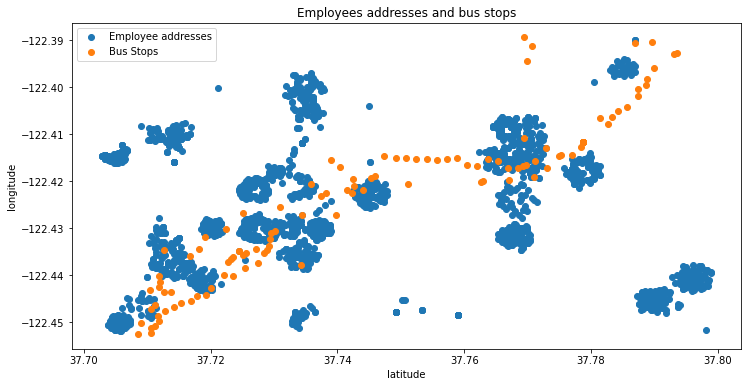

In [101]:
clusterer.plot_original_data()

In [102]:
clusterer.plot_map_box_original_data()

In [103]:
# convert centers from numpy array to panads dataframe 
def convert_to_df(arr):
    df = pd.DataFrame(arr)
    df.columns = ['latitude', 'longitude']
    return df 

### Apply kmean clustering 

In [104]:
km_labels, km_centers, km_score = clusterer.apply_kmeans_clustering(n_clusters=10)

# convert centers into data frame 
km_centers_df = convert_to_df(km_centers)

print("KMeans score: ", km_score)

KMeans score:  0.5777098016971755


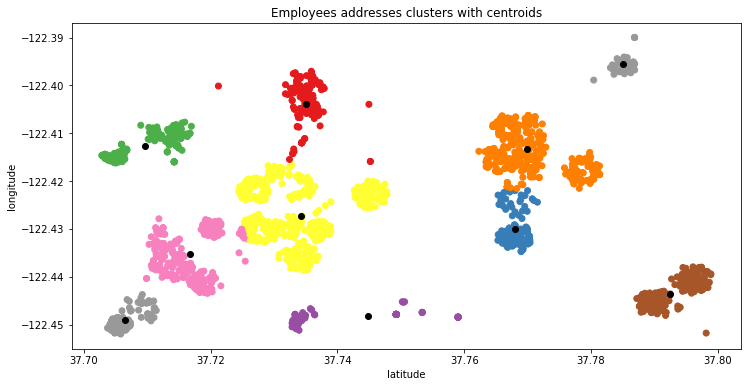

In [105]:
clusterer.plot_clusters(labels=km_labels, centers=km_centers_df)

In [106]:
clusterer.plot_map_box_clusters(labels=km_labels, centers=km_centers_df)

### Apply hierarical clustering 

In [107]:
# try complete, average and ward linkage methods and get the score of each one of them 
complete_labels, complete_centers, complete_score = clusterer.apply_hclustering(n_clusters=10, linkage='complete', affinity='manhattan')
average_labels, average_centers, average_score = clusterer.apply_hclustering(n_clusters=10, linkage='average', affinity='manhattan')
ward_labels, ward_centers, ward_score = clusterer.apply_hclustering(n_clusters=10, linkage='ward', affinity='euclidean')

print("Score of Hierarical clustering methods: \n Complete Linkage: {},\n Average Linking: {},\n Ward Linking: {}\n".format(complete_score, average_score, ward_score))

Score of Hierarical clustering methods: 
 Complete Linkage: 0.5547736693973802,
 Average Linking: 0.5776638750093852,
 Ward Linking: 0.5494260240570051



In [108]:
# convert centers into pandas dataframe
complete_centers_df = convert_to_df(complete_centers)

average_centers_df = convert_to_df(average_centers)

ward_centers_df = convert_to_df(ward_centers)

#### Plot clucters with complete linkage

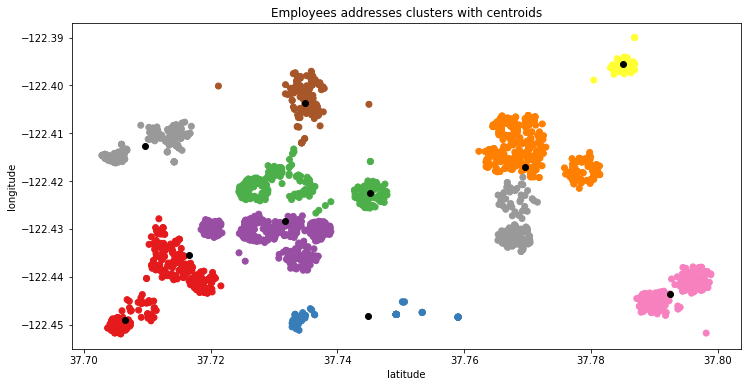

In [109]:
clusterer.plot_clusters(labels=complete_labels, centers=average_centers_df)

#### Plot clucters with average linkage

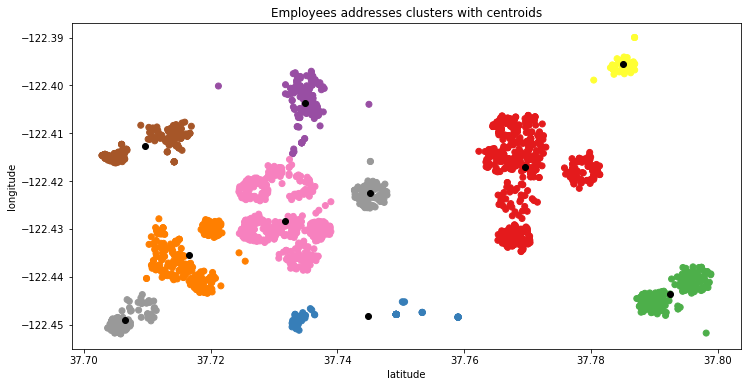

In [110]:
clusterer.plot_clusters(labels=average_labels, centers=average_centers_df)

#### Plot clucters with ward linkage

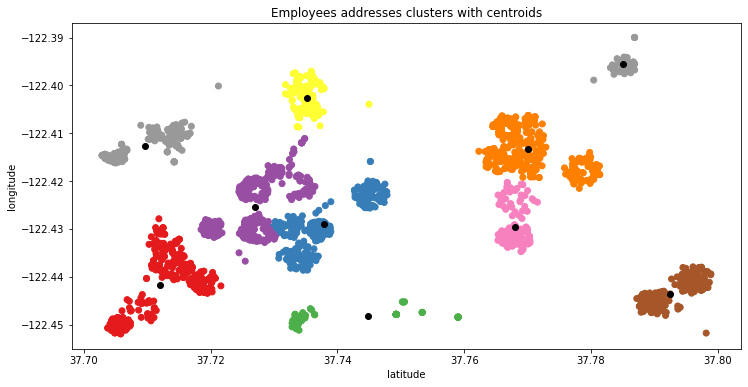

In [111]:
clusterer.plot_clusters(labels=ward_labels, centers=ward_centers_df)

**We see that the average linking method has the maximum score and make elegant and interesting clusters**

#### Plot clucters with average linkage on the map 

In [112]:
clusterer.plot_map_box_clusters(labels=average_labels, centers=average_centers_df)

<function matplotlib.pyplot.show(close=None, block=None)>

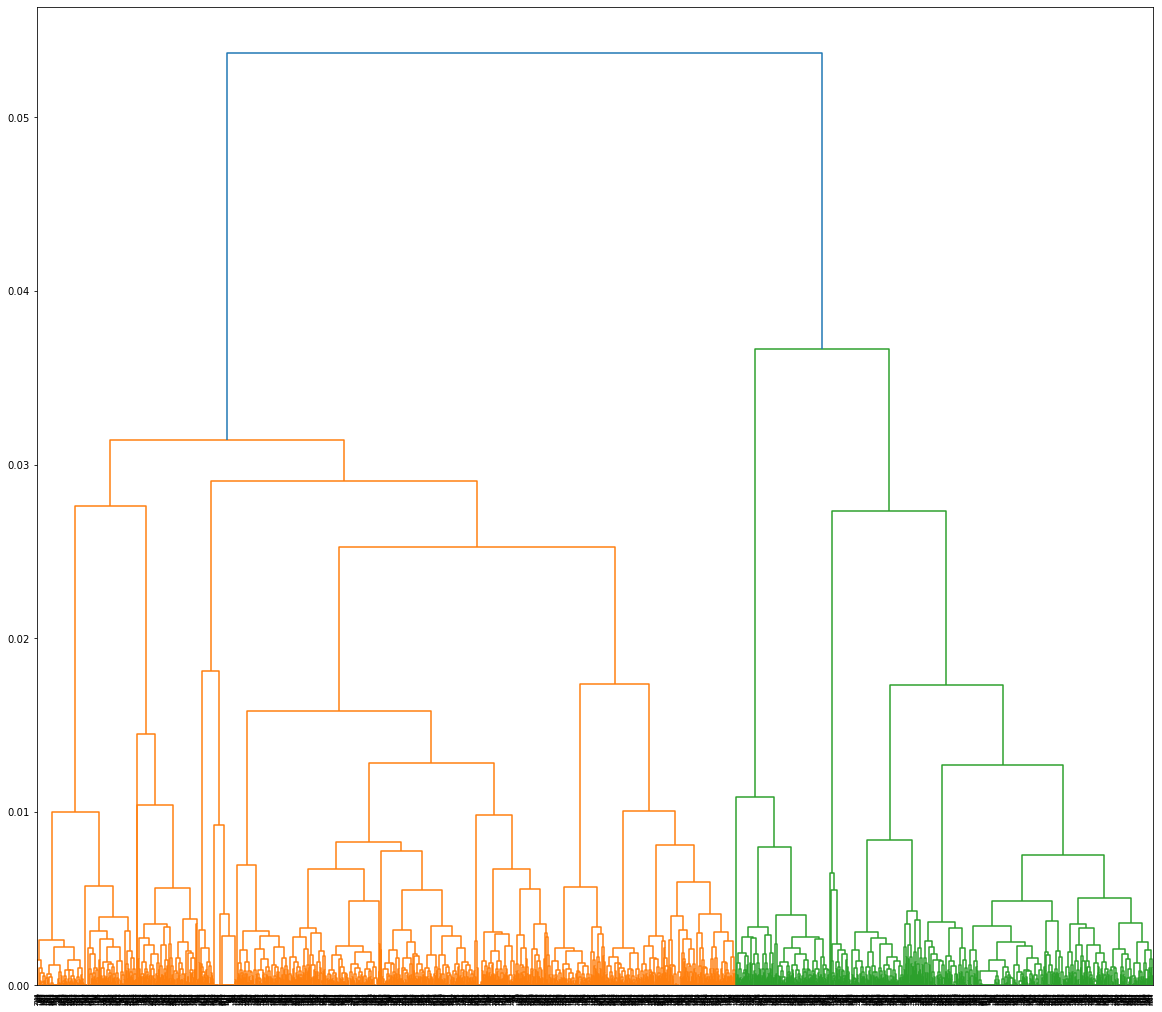

In [113]:
# plot dendrogram for average linkage 
linkage_matrix = linkage(employee_data_location, 'average')

plt.figure(figsize=(20, 18))
dendrogram(linkage_matrix)

plt.show

### Apply Gaussian Mixture Model 

In [114]:
gmm_labels, gmm_centers, gmm_score = clusterer.apply_gmm(n_clusters=10)
gmm_centers_df = convert_to_df(gmm_centers)

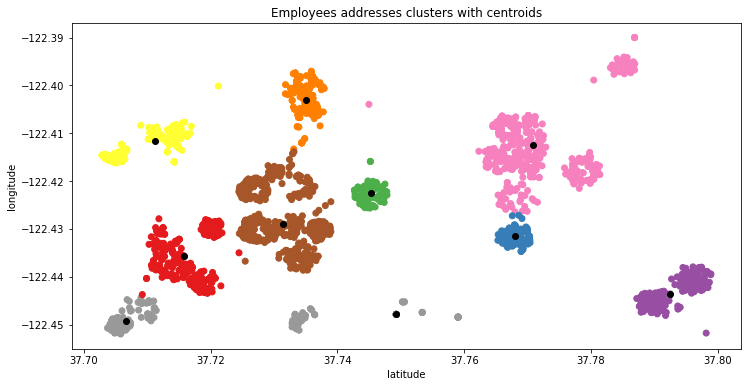

In [115]:
clusterer.plot_clusters(labels=gmm_labels, centers=gmm_centers_df)

In [116]:
clusterer.plot_map_box_clusters(labels=gmm_labels, centers=gmm_centers_df)

## Results:

In [117]:
print("The scores of the algorithms we used: \n \
       KMeans score: {} \n \
       Average hierarical score: {} \n \
       GMM score: {}".format(km_score, average_score, gmm_score))

The scores of the algorithms we used: 
        KMeans score: 0.5777098016971755 
        Average hierarical score: 0.5776638750093852 
        GMM score: 0.5600892455534239


##### KMeans clustering 

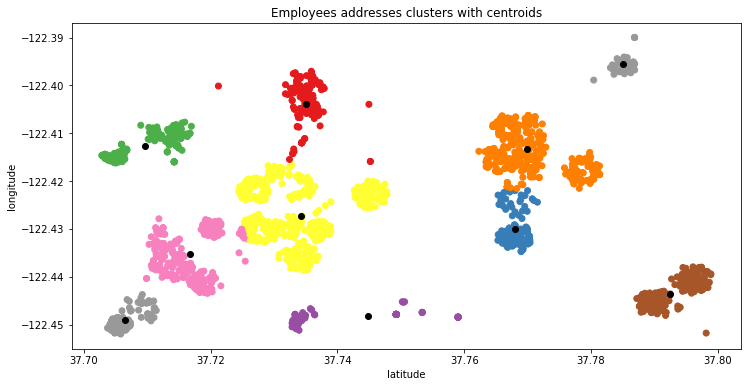

In [118]:
clusterer.plot_clusters(labels=km_labels, centers=km_centers_df)

##### Average hierarical clustering 

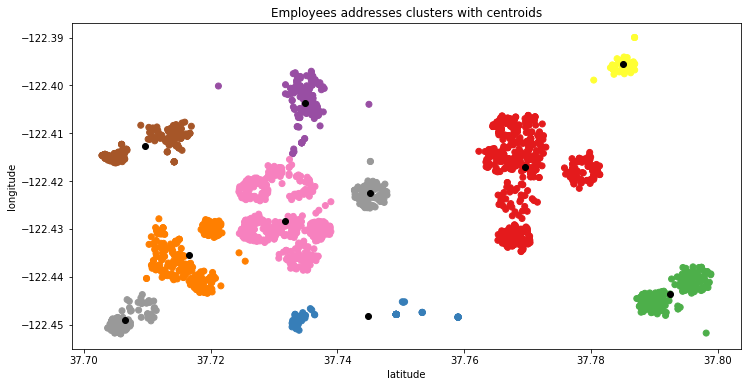

In [119]:
clusterer.plot_clusters(labels=average_labels, centers=average_centers_df)

##### GMM clustsering 

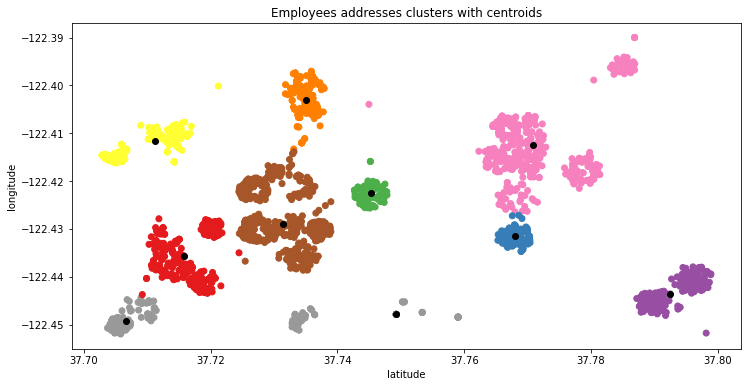

In [120]:
clusterer.plot_clusters(labels=gmm_labels, centers=gmm_centers_df)

## Conclusion: 

We will use the **hierarical clustering algorith with the average linkage** to get the best bus stops as it gives best score and best clusters to my mind  

### Get the best bus stops

We will use **Haversine Distance** to calculate the distance between the centroids of the clusters and the bus stops, then we will get the nearest bus stop to each cluster

In [121]:
def get_best_stops(bus_stops_data, centroids):
    """Calculate the distances between centroids and bus stops and get the nearest 10 stops 
    Parameters: 
        bus_stops_data (df): contains the bus stops data 
        centroids (nparray): the centroids of the clusters 
    Return:
        best_stops (df): contains the location of the 10 bus stops 
    """
    # having an array of bus stops locations 
    bus_stops = bus_stops_data[['latitude', 'longitude']].to_numpy()
    
    # get the arguments of the 10 best bus stops 
    argmin_distances = []
    for centroid in centroids:
        distance_arr = hs.haversine_vector(centroid, bus_stops, comb=True)    # claculating distance 
        argmin_distances.append(distance_arr.argmin())   

    # get the location of each of them 
    best_bus_stops = []
    for argmin_distance in argmin_distances:
        best_bus_stops.append(bus_stops[argmin_distance])

    # get the bus stops  
    best_stops = pd.DataFrame(columns=bus_stops_data.columns)
    for i in range(10):
        data = bus_stops_data[(bus_stops_data['latitude']==best_bus_stops[i][0]) & (bus_stops_data['longitude']==best_bus_stops[i][1])]
        best_stops = pd.concat([best_stops, data])
    
    return best_stops

In [122]:
best_bus_stops = get_best_stops(bus_stops_data=bus_stops_data, centroids=average_centers)
best_bus_stops

,Street_One,Street_Two,response,latitude,longitude
6,MISSION ST,ERIE ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.76927,-122.41673
106,MISSION ST,BOSWORTH ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.73428,-122.43791
54,MISSION ST,LASKIE ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.77701,-122.41449
30,MISSION ST,CORTLAND AVE,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.73897,-122.41546
0,MISSION ST,ITALY AVE,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.71675,-122.43594
73,MISSION ST,SHAW ALY,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.78877,-122.3983
88,MISSION ST,ROLPH ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.71261,-122.43459
17,MISSION ST,TRUMBULL ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.73092,-122.42544
23,MISSION ST,OLIVER ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.70894,-122.45019
55,MISSION ST,29TH ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.74399,-122.42183


#### Plot best bus stops with our clusters 

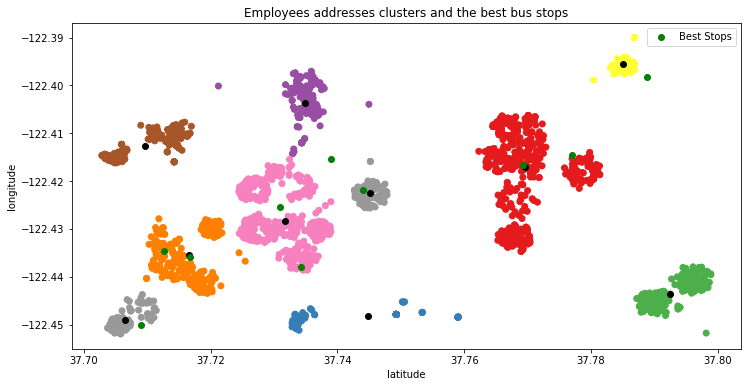

In [123]:
clusterer.plot_best_stops(labels=average_labels, centers=average_centers_df, best_stops=best_bus_stops)

In [124]:
best_bus_stops

,Street_One,Street_Two,response,latitude,longitude
6,MISSION ST,ERIE ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.76927,-122.41673
106,MISSION ST,BOSWORTH ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.73428,-122.43791
54,MISSION ST,LASKIE ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.77701,-122.41449
30,MISSION ST,CORTLAND AVE,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.73897,-122.41546
0,MISSION ST,ITALY AVE,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.71675,-122.43594
73,MISSION ST,SHAW ALY,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.78877,-122.3983
88,MISSION ST,ROLPH ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.71261,-122.43459
17,MISSION ST,TRUMBULL ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.73092,-122.42544
23,MISSION ST,OLIVER ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.70894,-122.45019
55,MISSION ST,29TH ST,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.74399,-122.42183


#### Plot them on the map 

In [125]:
clusterer.plot_map_box_best_stops(labels=average_labels, centers=average_centers_df, best_stops=best_bus_stops)

### Calculating the average walking distance per employee to their respective stops

In [126]:
# adding clusters to data frame of the employee 
employee_data['cluster'] = average_labels
employee_data.head()

,address,employee_id,response,latitude,longitude,cluster
0,"98 Edinburgh St, San Francisco, CA 94112, USA",206,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.727642,-122.427315,7
1,"237 Accacia St, Daly City, CA 94014, USA",2081,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.704180,-122.415820,6
2,"1835 Folsom St, San Francisco, CA 94103, USA",178,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.767930,-122.415100,0
3,"170 Cambridge St, San Francisco, CA 94134, USA",50,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.729660,-122.419720,7
4,"16 Roanoke St, San Francisco, CA 94131, USA",1863,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.736240,-122.431320,7


In [127]:
# saving each cluster on a single data frame
employee_clusters = []

for i in range(10):
    df = employee_data[employee_data.cluster == i]
    employee_clusters.append(df)

employee_clusters = np.array(employee_clusters, dtype=object)

# convert stops locations to nparray to be used in haversine 
best_bus_stops_locations = best_bus_stops[['latitude', 'longitude']].to_numpy(dtype='float64')

# calculate distances 
employee_clusters_distance = []
for i in range(10):
    
    cluster = employee_clusters[i]
    
    data= cluster[['latitude', 'longitude']].to_numpy()
    distance = hs.haversine_vector(best_bus_stops_locations[i], data, comb=True, unit=Unit.MILES)
    
    employee_clusters_distance.append(distance)
    
# getting distances in one Series 
distances = pd.DataFrame(columns=["distance"])
for i in range(10):
    dis = pd.DataFrame(employee_clusters_distance[i], columns=["distance"])
    distances = pd.concat([distances, dis], ignore_index=True)

# sort employee data by cluster
employee_data = employee_data.sort_values(by='cluster')
employee_data = pd.concat([employee_data, distances], axis=1)

In [128]:
distances.to_csv("output/employee_data.csv")

In [129]:
employee_data

,address,employee_id,response,latitude,longitude,cluster,distance
1095,"2300 16th St, San Francisco, CA 94103, USA",2049,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.765820,-122.409200,0,0.482908
987,"1190 Bryant St, San Francisco, CA 94103, USA",1803,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.770610,-122.409800,0,0.106369
989,"1599 Bryant St, San Francisco, CA 94103, USA",199,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.767030,-122.410495,0,0.446384
995,"1422 Market St, San Francisco, CA 94102, USA",1414,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.776280,-122.418160,0,0.427785
1001,"98 Brosnan St, San Francisco, CA 94103, USA",5,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.768785,-122.424297,0,0.139846
...,...,...,...,...,...,...,...
191,"1606 Guerrero St, San Francisco, CA 94110, USA",2168,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.745360,-122.422510,9,0.807586
313,"St. Luke's Hospital Garage, San Francisco, CA ...",1320,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.745190,-122.415900,9,0.531853
826,"125 Tiffany Ave, San Francisco, CA 94110, USA",1724,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.744970,-122.421020,9,1.991169
397,"54 Valley St, San Francisco, CA 94110, USA",764,{'Response': {'MetaInfo': {'Timestamp': '2022-...,37.744940,-122.423460,9,0.551047
